In [142]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score
from imblearn.over_sampling import SMOTE

In [143]:
import SVM_cluster
from importlib import reload  # Python 3.4+
#importlib.reload(mymodulesys.path.append('/Users/mengyanzhu/Documents/GitHub/msf-capstone-crm/SVM_optimizer')
reload(SVM_cluster)
from SVM_cluster import Median_SVM_Model
import gurobipy as gp
from gurobipy import GRB
from matplotlib.lines import Line2D
from matplotlib import cm
import numpy as np
#import statsmodels.api as sm 
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib import cm
import seaborn as sns 

In [144]:
file_name = '2021_stat.csv'
table = pd.read_csv(file_name, low_memory=False).dropna()

table.columns

Index(['LOAN_ID', 'ORIG_RATE', 'ORIG_AMOUNT', 'ORIG_TERM', 'OLTV', 'NUM_BO',
       'DTI', 'CSCORE_B', 'CSCORE_C', 'FTHB_FLAG', 'PUR_Cash_out',
       'PUR_Refinance', 'PUR_Purchase', 'PRO_Condominium', 'PRO_Co_operative',
       'PRO_Planned_Urban', 'PRO_Manufact_Home', 'PRO_Single_Family',
       'NUM_UNIT', 'OCC_Principal', 'OCC_Second', 'OCC_Investor', 'STATE',
       'ZIP', 'MSA', 'MI_PCT', 'MI_Borrower', 'MI_Lender', 'MI_Investor',
       'AQSN_DTE', 'ORIG_DTE', 'FRST_DTE', 'LAST_RATE', 'LAST_UPB',
       'LAST_ACTIVITY_DATE', 'DLQ_30_FLAG', 'DLQ_60_FLAG', 'DLQ_90_FLAG',
       'DLQ_120_FLAG', 'Ongoing', 'Current_DLQ', 'Prepaid_Matured',
       'Third_Party_Sale', 'Short_Sale', 'Repurchased', 'Deed_In_Lieu',
       'Non_Performing_NS', 'Reperforming_NS', 'COMPLETE_FLAG', 'NET_LOSS',
       'NET_SEV'],
      dtype='object')

In [145]:
# Columns to check
columns_to_check = ['DLQ_30_FLAG', 'DLQ_60_FLAG', 'DLQ_90_FLAG', 'DLQ_120_FLAG']

# Create the new column
table['DLQ_FLAG'] = (table[columns_to_check].sum(axis=1) > 0).astype(int)

# Drop the old columns
table = table.drop(columns=columns_to_check)

In [146]:
table.columns

Index(['LOAN_ID', 'ORIG_RATE', 'ORIG_AMOUNT', 'ORIG_TERM', 'OLTV', 'NUM_BO',
       'DTI', 'CSCORE_B', 'CSCORE_C', 'FTHB_FLAG', 'PUR_Cash_out',
       'PUR_Refinance', 'PUR_Purchase', 'PRO_Condominium', 'PRO_Co_operative',
       'PRO_Planned_Urban', 'PRO_Manufact_Home', 'PRO_Single_Family',
       'NUM_UNIT', 'OCC_Principal', 'OCC_Second', 'OCC_Investor', 'STATE',
       'ZIP', 'MSA', 'MI_PCT', 'MI_Borrower', 'MI_Lender', 'MI_Investor',
       'AQSN_DTE', 'ORIG_DTE', 'FRST_DTE', 'LAST_RATE', 'LAST_UPB',
       'LAST_ACTIVITY_DATE', 'Ongoing', 'Current_DLQ', 'Prepaid_Matured',
       'Third_Party_Sale', 'Short_Sale', 'Repurchased', 'Deed_In_Lieu',
       'Non_Performing_NS', 'Reperforming_NS', 'COMPLETE_FLAG', 'NET_LOSS',
       'NET_SEV', 'DLQ_FLAG'],
      dtype='object')

In [147]:


table = table[[
    'ORIG_RATE', 'ORIG_AMOUNT', 'ORIG_TERM', 'OLTV', 'NUM_BO', 'DTI', 'CSCORE_B', # 'CSCORE_C', 
    'FTHB_FLAG', 'PUR_Cash_out', 'PUR_Refinance', 'PUR_Purchase', 'NUM_UNIT', 
    'OCC_Principal', 'OCC_Second', 'OCC_Investor', 'MI_PCT', 'DLQ_FLAG', 'Ongoing', 
    'Current_DLQ', 'Prepaid_Matured']]

# Definition of Bad Loans: once had a 30-day delinquency in performance history
# Definition of Good Loans: no delinquency and continuous payments up to current
table = table[ (table['DLQ_FLAG'] == 1) | ( (table['DLQ_FLAG'] == 0) & (table['Ongoing'] == 1) ) ]

X = table.drop(columns=['DLQ_FLAG', 'Ongoing', 'Current_DLQ', 'Prepaid_Matured'])
y = table['DLQ_FLAG']

In [148]:
table.columns

Index(['ORIG_RATE', 'ORIG_AMOUNT', 'ORIG_TERM', 'OLTV', 'NUM_BO', 'DTI',
       'CSCORE_B', 'FTHB_FLAG', 'PUR_Cash_out', 'PUR_Refinance',
       'PUR_Purchase', 'NUM_UNIT', 'OCC_Principal', 'OCC_Second',
       'OCC_Investor', 'MI_PCT', 'DLQ_FLAG', 'Ongoing', 'Current_DLQ',
       'Prepaid_Matured'],
      dtype='object')

In [149]:
num_col = ['ORIG_RATE', 'ORIG_AMOUNT', 'ORIG_TERM', 'OLTV', 'NUM_BO', 'DTI', 'CSCORE_B', # 'CSCORE_C', 
           'NUM_UNIT', 'MI_PCT']
cat_col = ['FTHB_FLAG', 'PUR_Cash_out', 'PUR_Refinance', 'PUR_Purchase', 'OCC_Principal', 'OCC_Second', 'OCC_Investor']
scaler = StandardScaler()
X[num_col] = scaler.fit_transform(X[num_col])
X = pd.concat([X[num_col], X[cat_col]], axis=1)

X

,ORIG_RATE,ORIG_AMOUNT,ORIG_TERM,OLTV,NUM_BO,DTI,CSCORE_B,NUM_UNIT,MI_PCT,FTHB_FLAG,PUR_Cash_out,PUR_Refinance,PUR_Purchase,OCC_Principal,OCC_Second,OCC_Investor
0,-1.861115,2.298151,-1.690565,0.073897,-0.910715,1.446057,0.845006,-0.110637,-0.469892,0,0,1,0,1,0,0
1,-0.684411,2.414376,0.611493,0.661564,1.023410,-0.063434,0.707428,-0.110637,-0.469892,1,0,0,1,1,0,0
3,-0.378468,2.954479,0.611493,1.302655,-0.910715,0.137832,0.913794,-0.110637,2.365328,1,0,0,1,1,0,0
4,-0.684411,3.193766,0.611493,-2.063073,1.023410,-0.365332,0.730358,-0.110637,-0.469892,0,0,1,0,1,0,0
5,-0.966820,2.202436,0.611493,-0.353497,-0.910715,-0.164066,0.202978,-0.110637,-0.469892,0,0,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4782086,2.280883,-0.669001,0.611493,0.394443,1.023410,-0.566597,-0.347331,-0.110637,-0.469892,0,1,0,0,0,0,1
4782088,0.186350,1.142739,0.611493,1.195807,-0.910715,0.238465,-0.484908,-0.110637,1.892791,1,0,0,1,1,0,0
4782089,-0.966820,-0.887777,-1.690565,0.127322,1.023410,-0.264699,0.202978,-0.110637,-0.469892,0,1,0,0,1,0,0
4782090,-0.966820,-0.224612,-1.690565,-0.887739,1.023410,0.640995,-0.140965,-0.110637,-0.469892,0,1,0,0,1,0,0


In [150]:
def RBF(X, gamma):
    
    # Free parameter gamma
    if gamma == None:
        gamma = 1.0/X.shape[1]
        
    # RBF kernel Equation
    K = np.exp(-gamma * np.sum((X - X[:,np.newaxis])**2, axis = -1))
    
    return K

In [151]:
X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(X, y, test_size=0.99999, random_state=42)

In [152]:
# Split the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X_train_1, y_train_1, test_size=0.4, random_state=42)
print(y_train.value_counts())
print(y_test.value_counts())







smote = SMOTE(sampling_strategy='auto', k_neighbors=2, random_state=9)


X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

n_samples, n_features = X_train_smote.shape

DLQ_FLAG
0    22
1     3
Name: count, dtype: int64
DLQ_FLAG
0    13
1     4
Name: count, dtype: int64


In [153]:
if isinstance(X_train_smote, pd.DataFrame):
    X_train_smote = X_train_smote.to_numpy()


if isinstance(y_train_smote, pd.DataFrame):
    y_train_smote = y_train_smote.to_numpy()   


if isinstance(X_test, pd.DataFrame):
    X_test = X_test.to_numpy()


if isinstance(y_test, pd.DataFrame):
    y_test= y_test.to_numpy()   

In [154]:
X_train_smote = RBF(X_train_smote, gamma=None)

In [155]:
X_train_smote[:,1]

array([2.47714611e-04, 1.00000000e+00, 1.43641838e-04, 2.52251162e-04,
       2.06208032e-04, 2.01339341e-04, 3.88520918e-04, 3.79131616e-04,
       1.96415095e-04, 3.22281328e-04, 5.05338466e-04, 2.36543843e-04,
       4.46091098e-04, 4.52466459e-04, 5.11179650e-04, 3.00857779e-04,
       2.71626208e-04, 4.08913314e-04, 3.66718217e-04, 2.99939670e-04,
       2.27909196e-04, 1.92316166e-04, 2.61782016e-04, 2.79109194e-04,
       1.74765284e-04, 4.13081270e-04, 9.03195740e-04, 2.31309085e-02,
       2.44571188e-01, 8.16680544e-01, 3.23457272e-02, 5.34743774e-04,
       5.05019723e-01, 2.89996820e-01, 5.55023003e-04, 5.25085448e-03,
       1.75400400e-01, 8.59541608e-01, 7.42920317e-01, 5.75450477e-04,
       5.18309004e-03, 5.39286058e-04, 1.12943679e-03, 5.12745915e-04])

In [157]:
# Create a new Gurobi model
model = gp.Model("SVM_Med")

# Set a time limit in seconds
#time_limit = 2000  # 10 minutes
#model.setParam(GRB.Param.TimeLimit, time_limit)
#model.setParam('MIPGap', 0.05)

# Optionally, enable verbose logging
model.setParam(GRB.Param.LogToConsole, 1)




# Regularization parameter
# Define the powers of 10 for C1, C2, C3
powers_C1 = [10**i for i in range(-1, 2)]  # 10^-5 to 10^5
powers_C2 = [10**i for i in range(-3, 1)]  # 10^-5 to 10^5
powers_C3 = [10**i for i in range(-2, 1)]  # 10^-3 to 10^0

# Number of options for C1, C2, and C3
num_C1 = len(powers_C1)
num_C2 = len(powers_C2)
num_C3 = len(powers_C3)

# Create binary decision variables for C1, C2, C3
C1_binary = model.addVars(num_C1, vtype=GRB.BINARY, name="C1_binary")
C2_binary = model.addVars(num_C2, vtype=GRB.BINARY, name="C2_binary")
C3_binary = model.addVars(num_C3, vtype=GRB.BINARY, name="C3_binary")

# Define auxiliary variables for the actual C1, C2, C3 values
C1 = model.addVar(name="C1")
C2 = model.addVar(name="C2")
C3 = model.addVar(name="C3")


# Link binary variables to C1, C2, C3 correctly
model.addConstr(
C1 == gp.quicksum(C1_binary[j] * powers_C1[j] for j in range(num_C1)), 
name="C1_constraint"
)
model.addConstr(
C2 == gp.quicksum(C2_binary[j] * powers_C2[j] for j in range(num_C2)), 
name="C2_constraint"
)
model.addConstr(
C3 == gp.quicksum(C3_binary[j] * powers_C3[j] for j in range(num_C3)), 
name="C3_constraint"
)


# Ensure only one binary variable is selected for each C
model.addConstr(gp.quicksum(C1_binary) == 1, "C1_selection")
model.addConstr(gp.quicksum(C2_binary) == 1, "C2_selection")
model.addConstr(gp.quicksum(C3_binary) == 1, "C3_selection")





# Add variables for w (decision boundary), b (bias), and xi (slack variables)
w = model.addVars(n_samples, lb=-GRB.INFINITY, name="w")
b = model.addVar(lb=-GRB.INFINITY, name="b")
ei = model.addVars(n_samples,lb=0, name="ei")  # slack variables
theta_i = model.addVars(n_samples,vtype=GRB.BINARY, name="theta_i")
xi = model.addVars(n_samples, vtype=GRB.BINARY,lb=0, name="xi")  # relabelled obeservations
di = model.addVars(n_samples, lb=0, name="di")  # distance from observations to their reference points
M1 = model.addVar(lb=0, name="M1")
M2 = model.addVar(lb=0, name="M2")
M3 = model.addVar(lb=0, name="M3")

K_plus = model.addMVar(n_samples, name="K_plus")
K_minus = model.addMVar(n_samples, name="K_minus")

# Introduce auxiliary variables to hold absolute differences for L1 norms
abs_diffs_plus = model.addVars(n_samples, n_features, name="abs_diffs_plus")
abs_diffs_minus = model.addVars(n_samples,  n_features, name="abs_diffs_minus")


#add l2 contraint
l2_2 = model.addVars(n_samples,n_samples, lb=0, name="l2_2")


# Loop to define absolute differences for K^+ (L1 norm)
for i in range(n_samples):
    for j in range(n_features):
        model.addConstr(abs_diffs_plus[i,j] >= X_train_smote[i, j] - K_plus[j], name=f"abs_diff_plus_pos_{i}_{j}")
        model.addConstr(abs_diffs_plus[i,j] >= -(X_train_smote[i, j] - K_plus[j]), name=f"abs_diff_plus_neg_{i}_{j}")


# Loop to define absolute differences for K^- (L1 norm)
for i in range(n_samples):
    for j in range(n_features):
        model.addConstr(abs_diffs_minus[i, j] >= X_train_smote[i, j] - K_minus[j], name=f"abs_diff_minus_pos_{i}_{j}")
        model.addConstr(abs_diffs_minus[i, j] >= -(X_train_smote[i, j] - K_minus[j]), name=f"abs_diff_minus_neg_{i}_{j}")


# Objective: 0.5 * ||w|| + C * sum(xi)


w_abs = model.addVars(n_samples,lb=0, name="w_abs")  # Auxiliary variable for |x|

# Add constraints for the absolute value
for i in range(n_samples):
    model.addConstr( w_abs[i] >= w[i], "abs_x_positive")
    model.addConstr( w_abs[i] >= -w[i], "abs_x_negative")

model.setObjective(
    0.5 * gp.quicksum( w_abs[i] for i in range(n_samples)) + C1 * sum(ei[i] for i in range(n_samples))
                                                                + C2 * sum(xi[i] for i in range(n_samples))
                                                                   + C3 * sum(di[i] for i in range(n_samples)),
    GRB.MINIMIZE
)

'''model.setObjective(
    0.5 * gp.quicksum( w_abs[i] for i in range(n_samples)) + C1 * sum(ei[i] for i in range(n_samples))
                                                                + C2 * sum(xi[i] for i in range(n_samples))
                                                                    + C3 * sum(di[i] for i in range(n_samples)),
    GRB.MINIMIZE
)'''

###set up Constraint for M3



# Loop over each point to calculate the max norm part
max_norms = []
max_norms_2 = []


for i in range(n_samples):
    # Calculate the sum term: sum_{j=1}^{d} (x[i][j] + 2)
    sum_term = gp.quicksum(X_train_smote[i, j] + 2 for j in range(n_features))
    
    # Create auxiliary variable for the maximum L1 norm for each point i
    max_norm_i = model.addVar(name=f"max_norm_i_{i}")
    max_norm_i_2 = model.addVar(name=f"max_norm_i_2_{i}")
    
    for j in range(n_samples):
        if i != j:  # Avoid self-comparison
            # Define the L1 norm (Manhattan distance) between points i and j
            l1_norm_expr = gp.quicksum(model.addVar(lb=0, name=f"abs_diff_M3{i}_{j}_{k}") for k in range(n_features))
            
            # Add constraints for each absolute value
            for k in range(n_features):
                abs_diff_M3 = model.addVar(lb=0, name=f"abs_diff_M3_{i}_{j}_{k}")
                model.addConstr(abs_diff_M3 >= X_train_smote[i, k] - X_train_smote[j, k], name=f"abs_diff_pos_M3{i}_{j}_{k}")
                model.addConstr(abs_diff_M3 >= X_train_smote[j, k] - X_train_smote[i, k], name=f"abs_diff_neg_M3{i}_{j}_{k}")

                # Add each absolute difference to the L1 norm expression
                l1_norm_expr += abs_diff_M3
                
            # Add constraint to ensure max_norm_i captures the maximum norm
            model.addConstr(max_norm_i >= l1_norm_expr, name=f"max_norm_constraint_M3{i}_{j}")
            # Define the L2 norm expression (squared L2 norm, no square root)

            
            l2_norm_expr = gp.quicksum((X_train_smote[i, k] - X_train_smote[j, k])**2 for k in range(n_features))
            model.addConstr(l2_2[i,j]**2 >= l2_norm_expr)
            
            # Add constraint to ensure max_norm_i captures the maximum L2 norm

            model.addConstr(max_norm_i_2 >= l2_2[i,j], name=f"max_norm_constraint_L2_{i}_{j}")
            #model.addConstr(max_norm_i_2 >= l2_norm_expr, name=f"max_norm_constraint_L2_{i}_{j}")

    # Append max_norm_i to max_norms list to calculate the maximum later
    max_norms.append(max_norm_i)
    max_norms_2.append(max_norm_i_2)


# Now find the maximum of the max_norms
max_of_max_norms = model.addVar(name="max_of_max_norms")  # Variable to hold the maximum of the max norms

# Add constraints to find the maximum
for idx, max_norm_2 in enumerate(max_norms_2):
    model.addConstr(max_of_max_norms >= max_norm_2, name=f"max_constraint_{idx}")


# Loop over each point
for i in range(n_samples):
    # Create an auxiliary variable for the maximum norm
    max_norm_expr = model.addVar(name=f"max_norm_i_{i}")  # Auxiliary variable for M2 constraint
    
    for j in range(n_samples):
        if i != j:  # Avoid self-comparison
            # Define the L1 norm (Manhattan distance) as the sum of absolute differences
            
            norm_expr = gp.LinExpr()

            # Add constraints for each absolute value
            for k in range(n_features):
                abs_diff_M2 = model.addVar(lb=0, name=f"abs_diff_M2_{i}_{j}_{k}")
                model.addConstr(abs_diff_M2 >= X_train_smote[i, k] - X_train_smote[j, k], name=f"abs_diff_pos_M2{i}_{j}_{k}")
                model.addConstr(abs_diff_M2 >= X_train_smote[j, k] - X_train_smote[i, k], name=f"abs_diff_neg_M2{i}_{j}_{k}")
                # Add each absolute difference to the L1 norm expression
                norm_expr += abs_diff_M2
                
            # Add the constraint for max norm
            model.addConstr(max_norm_expr >= norm_expr, name=f"max_norm_constraint_M2{i}_{j}")




# Constraints: y_i * (w * x_i + b) >= 1 - xi_i
for i in range(n_samples):
    model.addConstr(
        y_train_smote[i] * (gp.quicksum(w[j] * X_train_smote[i, j] for j in range(n_features)) + b) >= -M1* xi[i],
        name=f"margin_constraint_{i}"

    )
    L1_norm_plus = gp.quicksum(abs_diffs_plus[i, j] for j in range(n_features))  # Calculate the L1 norm for K^+
    model.addConstr(di[i] >= L1_norm_plus - M2 * (1 - theta_i[i]), name=f"d_constraint_plus_{i}")
    
    L1_norm_minus = gp.quicksum(abs_diffs_minus[i, j] for j in range(n_features))  # Calculate the L1 norm for K^-
    model.addConstr(di[i] >= L1_norm_minus - M2 * theta_i[i], name=f"d_constraint_minus_{i}")




    model.addConstr(
        gp.quicksum(w[j] * X_train_smote[i, j] for j in range(n_features)) + b >= 1-ei[i]-M3* (1-theta_i[i]),
        name = f"cluster_+_{i}"
    )
    model.addConstr(
        gp.quicksum(w[j] * X_train_smote[i, j] for j in range(n_features)) + b <= -1+ei[i]+M3* theta_i[i],
        name = f"cluster_+_{i}"
    )


    model.addConstr(M1 >= y_train_smote[i] * (gp.quicksum(X_train_smote[i, j]  + 1 for j in range(n_features))),name="M1_constraint" ) #add M1 Constraint
    
###Add Constraint for M1, M2, M3

# Add the constraint: M3 > sum_{j=1}^d x_{ij} + 2 + max{ ||x_i - x_j||_2 }
model.addConstr(M3 >= sum_term + max_of_max_norms, name=f"M3_constraint_{i}")
        

# Add the constraint M2
model.addConstr(M2 >= max_norm_expr, name="M2_constraint")

# Add the constraint: M1 > max{ y_i * (sum_{j=1}^d x_{ij} + 1) }

# model.addConstr(M1>= gp.quicksum(y_train_smote[i] * (gp.quicksum(X_train_smote[i, j] for j in range(n_features)) + 1) for i in range(n_samples))+ 10e-6) #add M1 Constraint
    



# Solve the model
model.optimize()


# Check the optimization result
if model.status == GRB.OPTIMAL: 
    print("Optimal solution found.")
    


    
    
elif model.status == GRB.TIME_LIMIT:
    print("Time limit reached. Best solution found so far.")
    
    
   
    
else:
    print("No optimal solution found.")
    


/var/folders/xk/cmg2qxpd3_33lsrdb28qrgpr0000gn/T/ipykernel_81334/1425095372.py:53: DeprecationWarning: Calling quicksum on a tupledict is deprecated, use .sum() instead.
  model.addConstr(gp.quicksum(C1_binary) == 1, "C1_selection")
/var/folders/xk/cmg2qxpd3_33lsrdb28qrgpr0000gn/T/ipykernel_81334/1425095372.py:54: DeprecationWarning: Calling quicksum on a tupledict is deprecated, use .sum() instead.
  model.addConstr(gp.quicksum(C2_binary) == 1, "C2_selection")
/var/folders/xk/cmg2qxpd3_33lsrdb28qrgpr0000gn/T/ipykernel_81334/1425095372.py:55: DeprecationWarning: Calling quicksum on a tupledict is deprecated, use .sum() instead.
  model.addConstr(gp.quicksum(C3_binary) == 1, "C3_selection")


Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (mac64[arm] - Darwin 24.0.0 24A348)

CPU model: Apple M1 Pro
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 129764 rows, 94662 columns and 225439 nonzeros
Model fingerprint: 0xcb67a9a4
Model has 132 quadratic objective terms
Model has 2112 quadratic constraints
Variable types: 94564 continuous, 98 integer (98 binary)
Coefficient statistics:
  Matrix range     [1e-03, 1e+01]
  QMatrix range    [1e+00, 1e+00]
  QLMatrix range   [1e-04, 1e+00]
  Objective range  [5e-01, 5e-01]
  QObjective range [2e+00, 2e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [9e-07, 4e+01]
  QRHS range       [2e-04, 6e+00]
Presolve removed 126854 rows and 92963 columns
Presolve time: 0.02s
Presolved: 3527 rows, 2141 columns, 10562 nonzeros
Presolved model has 220 SOS constraint(s)
Presolved model has 88 bilinear constraint(s)
         in product terms.
         Presolve was not able to compute smaller 

In [ ]:
from sklearn.decomposition import PCA


In [158]:

y_train = y_train.to_numpy()
y_train

array([0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0])

In [160]:
model = gp.Model("SVM")

# Add variables: w (n_features), b (scalar), and xi (n_samples)
w = model.addVars(n_features, lb=-GRB.INFINITY, name="w")
b = model.addVar(lb=-GRB.INFINITY, name="b")
xi = model.addVars(n_samples, lb=0, name="xi")

# Objective: Minimize 1/2 * ||w||^2 + C * sum(xi)
obj = gp.QuadExpr()
obj += 0.5 * sum(w[i] * w[i] for i in range(n_features))  # 1/2 * ||w||^2
obj += 1 * sum(xi[i] for i in range(n_samples))          # C * sum(xi)
model.setObjective(obj, GRB.MINIMIZE)

# Constraints: y_i * (w^T x_i + b) >= 1 - xi_i
for i in range(n_samples):
    model.addConstr(
        y_train_smote[i] * (sum(w[j] * X_train_smote[i, j] for j in range(n_features)) + b) >= 1 - xi[i],
        name=f"margin_{i}"
    )

# Constraints: xi_i >= 0 (implicitly satisfied since xi variables are non-negative)

# Optimize the model
model.optimize()





Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (mac64[arm] - Darwin 24.0.0 24A348)

CPU model: Apple M1 Pro
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 44 rows, 61 columns and 418 nonzeros
Model fingerprint: 0x6faacf90
Model has 16 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e-04, 1e+00]
  Objective range  [1e+00, 1e+00]
  QObjective range [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+00]
Presolve removed 44 rows and 61 columns
Presolve time: 0.00s
Presolve: All rows and columns removed

Barrier solved model in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective 2.20000000e+01


1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
Test Evaluation:
ROC Score: 0.5000
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        13
           1       0.24      1.00      0.38         4

    accuracy                           0.24        17
   macro avg       0.12      0.50      0.19        17
weighted avg       0.06      0.24      0.09        17

Accuracy: 0.2353
Training Accuracy: 0.12


/Users/mengyanzhu/Documents/GitHub/msf-capstone-crm/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/mengyanzhu/Documents/GitHub/msf-capstone-crm/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/mengyanzhu/Documents/GitHub/msf-capstone-crm/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to cont

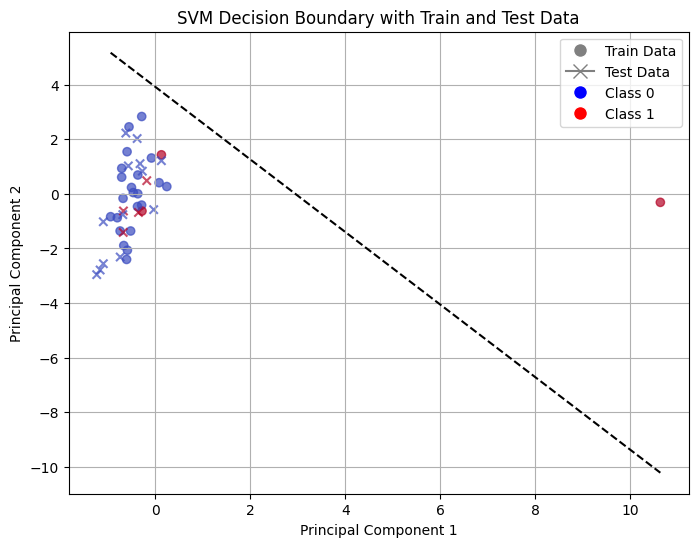

In [162]:
if model.status == GRB.TIME_LIMIT or model.status == GRB.OPTIMAL: 
    w_values = [w[j].x for j in range(n_features)]
    b_value = b.x
    '''print("C1:", C1.X, "C2:", C2.X, "C3:", C3.X)
    print("M1:", M1.X, "M2:", M2.X, "M3:", M3.X)
    print("Optimal weights (w):", w_values)
    print("Optimal bias (b):", b_value)'''

    
    predictions = []
    for i in range(len(X_test)):
        prediction = sum(w_values[j] * X_test[i, j] for j in range(n_features)) + b_value
        print(prediction)
        threshold = 0
        predictions.append(1 if prediction >= threshold else 0)  # Classify as 1 or 0
   

    # Evaluate model performance
    #auc_score = auc(y_test, predictions)
    roc_score = roc_auc_score(y_test, predictions)
    accuracy = accuracy_score(y_test, predictions)
    #precision = precision_score(y_test, predictions, average='binary')
    #recall = recall_score(y_test, predictions, average='binary')
    
    
    # Print evaluation results

    print("Test Evaluation:")
    print(f"ROC Score: {roc_score:.4f}")
    print(classification_report(y_test,predictions))
    print(f"Accuracy: {accuracy:.4f}")
    #print(f"Precision: {precision:.4f}")
    #print(f"Recall: {recall:.4f}")
    
    if isinstance(X_train, pd.DataFrame):
        X_train = X_train.to_numpy()


    
    
    
    train_predictions = [1 if sum(w_values[j] * X_train[i, j] for j in range(n_features)) + b_value >= threshold else 0 for i in range(0,len(X_train))]
    
    
    
    train_accuracy = sum(y_train[i] == train_predictions[i] for i in range(len(y_train))) / len(y_train)

    print("Training Accuracy:", train_accuracy)



    


    # Step 1: Apply PCA to reduce to 2D
    pca = PCA(n_components=2)  # 2D for visualization
    
    X_train_reduced = pca.fit_transform(X_train)
    X_test_reduced = pca.transform(X_test)  # Apply the same PCA transformation to test data

    # Step 2: Assuming you have the weights and bias from the trained model
    
    # Here, we simulate the decision boundary for illustration
    weights_reduced = pca.transform([w_values])[0]
    # Decision boundary (hyperplane) equation in reduced space
    x1_values = np.linspace(X_train_reduced[:, 0].min(), X_train_reduced[:, 0].max(), 100)
    x2_values = -( weights_reduced[0] * x1_values + b_value) /  weights_reduced[1]  # SVM equation for decision boundary

    # Step 3: Plot
    plt.figure(figsize=(8, 6))

    # Plot training data
    train_scatter = plt.scatter(X_train_reduced[:, 0], X_train_reduced[:, 1], c=y_train, cmap='coolwarm', alpha=0.7, label='Train Data')

    # Plot test data
    test_scatter = plt.scatter(X_test_reduced[:, 0], X_test_reduced[:, 1], c=y_test, cmap='coolwarm', alpha=0.7, marker='x', label='Test Data')


    
    
    
    
    
    
    # Plot the decision boundary
    plt.plot(x1_values, x2_values, color='black', linestyle='--', label='Decision Boundary')

    # Add labels and legend
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.title('SVM Decision Boundary with Train and Test Data')
    train_patch = Line2D([0], [0], marker='o', color='w', markerfacecolor='gray', markersize=10, label='Train Data')
    test_patch = Line2D([0], [0], marker='x', color='gray', markersize=10, label='Test Data')
    class_0_patch = Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=10, label='Class 0')
    class_1_patch = Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=10, label='Class 1')
    # Add legend manually
    plt.legend(handles=[train_patch, test_patch, class_0_patch, class_1_patch], loc='best')
    plt.grid(True)
    plt.show()

C1: 1.0 C2: 0.009999999999999995 C3: 0.1
M1: 24.275310953986853 M2: 8.31644940932915 M3: 41.77466166201402
Optimal weights (w): [0.0, 0.0, 0.043637107898891254, 1.6132325964948364, 0.0, 0.0, 0.0, 0.0, 0.0, 0.88443096236946, 0.0, 0.0, 1.5109894903338452, 2.661203109640043, 0.0, 0.0]
Optimal bias (b): -1.2741974218161551
-0.2769979751042244
3.2566182974025555
3.991935923039791
0.06774507587204703
-0.19081221236015633
-1.3254965221162485
0.4986738895923859
3.8195643975516544
1.8776460934974708
4.703995359921115
5.284722364200808
2.480946432705945
-1.928796861324723
-2.0763434573035893
-0.9472684188642175
-2.2208392018326855
0.6710454150805216
Test Evaluation:
ROC Score: 0.4423
              precision    recall  f1-score   support

           0       0.71      0.38      0.50        13
           1       0.20      0.50      0.29         4

    accuracy                           0.41        17
   macro avg       0.46      0.44      0.39        17
weighted avg       0.59      0.41      0.45  

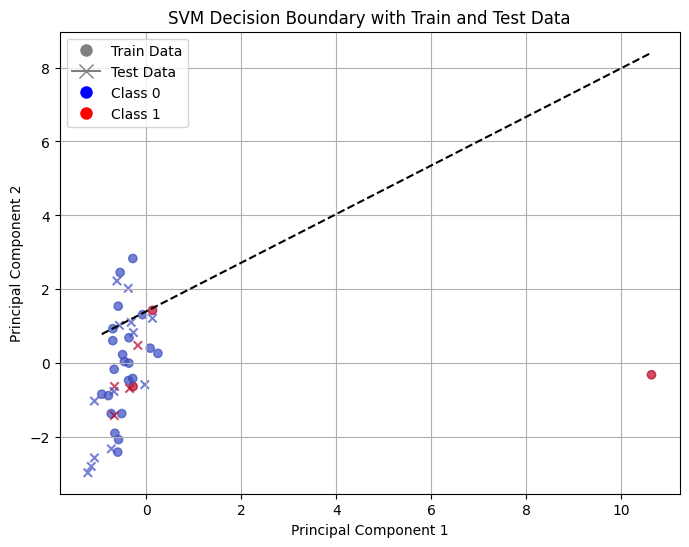

In [ ]:


if model.status == GRB.TIME_LIMIT or model.status == GRB.OPTIMAL: 
    w_values = [w[j].x for j in range(n_features)]
    b_value = b.x
    print("C1:", C1.X, "C2:", C2.X, "C3:", C3.X)
    print("M1:", M1.X, "M2:", M2.X, "M3:", M3.X)
    print("Optimal weights (w):", w_values)
    print("Optimal bias (b):", b_value)

    
    predictions = []
    for i in range(len(X_test)):
        prediction = sum(w_values[j] * X_test[i, j] for j in range(n_features)) + b_value
        print(prediction)
        threshold = 0
        predictions.append(1 if prediction >= threshold else 0)  # Classify as 1 or 0
   

    # Evaluate model performance
    #auc_score = auc(y_test, predictions)
    roc_score = roc_auc_score(y_test, predictions)
    accuracy = accuracy_score(y_test, predictions)
    #precision = precision_score(y_test, predictions, average='binary')
    #recall = recall_score(y_test, predictions, average='binary')
    
    
    # Print evaluation results

    print("Test Evaluation:")
    print(f"ROC Score: {roc_score:.4f}")
    print(classification_report(y_test,predictions))
    print(f"Accuracy: {accuracy:.4f}")
    #print(f"Precision: {precision:.4f}")
    #print(f"Recall: {recall:.4f}")
    
    if isinstance(X_train, pd.DataFrame):
        X_train = X_train.to_numpy()


    
    
    
    train_predictions = [1 if sum(w_values[j] * X_train[i, j] for j in range(n_features)) + b_value >= threshold else 0 for i in range(0,len(X_train))]
    
    
    
    train_accuracy = sum(y_train[i] == train_predictions[i] for i in range(len(y_train))) / len(y_train)

    print("Training Accuracy:", train_accuracy)



    


    # Step 1: Apply PCA to reduce to 2D
    pca = PCA(n_components=2)  # 2D for visualization
    
    X_train_reduced = pca.fit_transform(X_train)
    X_test_reduced = pca.transform(X_test)  # Apply the same PCA transformation to test data

    # Step 2: Assuming you have the weights and bias from the trained model
    
    # Here, we simulate the decision boundary for illustration
    weights_reduced = pca.transform([w_values])[0]
    # Decision boundary (hyperplane) equation in reduced space
    x1_values = np.linspace(X_train_reduced[:, 0].min(), X_train_reduced[:, 0].max(), 100)
    x2_values = -( weights_reduced[0] * x1_values + b_value) /  weights_reduced[1]  # SVM equation for decision boundary

    # Step 3: Plot
    plt.figure(figsize=(8, 6))

    # Plot training data
    train_scatter = plt.scatter(X_train_reduced[:, 0], X_train_reduced[:, 1], c=y_train, cmap='coolwarm', alpha=0.7, label='Train Data')

    # Plot test data
    test_scatter = plt.scatter(X_test_reduced[:, 0], X_test_reduced[:, 1], c=y_test, cmap='coolwarm', alpha=0.7, marker='x', label='Test Data')


    
    
    
    
    
    
    # Plot the decision boundary
    plt.plot(x1_values, x2_values, color='black', linestyle='--', label='Decision Boundary')

    # Add labels and legend
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.title('SVM Decision Boundary with Train and Test Data')
    train_patch = Line2D([0], [0], marker='o', color='w', markerfacecolor='gray', markersize=10, label='Train Data')
    test_patch = Line2D([0], [0], marker='x', color='gray', markersize=10, label='Test Data')
    class_0_patch = Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=10, label='Class 0')
    class_1_patch = Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=10, label='Class 1')
    # Add legend manually
    plt.legend(handles=[train_patch, test_patch, class_0_patch, class_1_patch], loc='best')
    plt.grid(True)
    plt.show()

In [ ]:
'''Explored 135013171 nodes (1512890115 simplex iterations) in 19652.43 seconds (11677.93 work units)
Thread count was 8 (of 8 available processors)

Solution count 10: 29.0676 29.1708 29.198 ... 31.6307

Optimal solution found (tolerance 5.00e-02)
Best objective 2.906760595792e+01, best bound 2.761422842767e+01, gap 5.0000%
Optimal solution found.'''

C1: 0.010000000000000009 C2: 0.009999999999999995 C3: 0.1
M1: 9.275310953986851 M2: 8.31644940932915 M3: 39.32226488239518
Optimal weights (w): [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Optimal bias (b): 1.0
Test Evaluation:
ROC Score: 0.5000
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        13
           1       0.24      1.00      0.38         4

    accuracy                           0.24        17
   macro avg       0.12      0.50      0.19        17
weighted avg       0.06      0.24      0.09        17

Accuracy: 0.2353


/Users/mengyanzhu/Documents/GitHub/msf-capstone-crm/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/mengyanzhu/Documents/GitHub/msf-capstone-crm/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/mengyanzhu/Documents/GitHub/msf-capstone-crm/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to cont

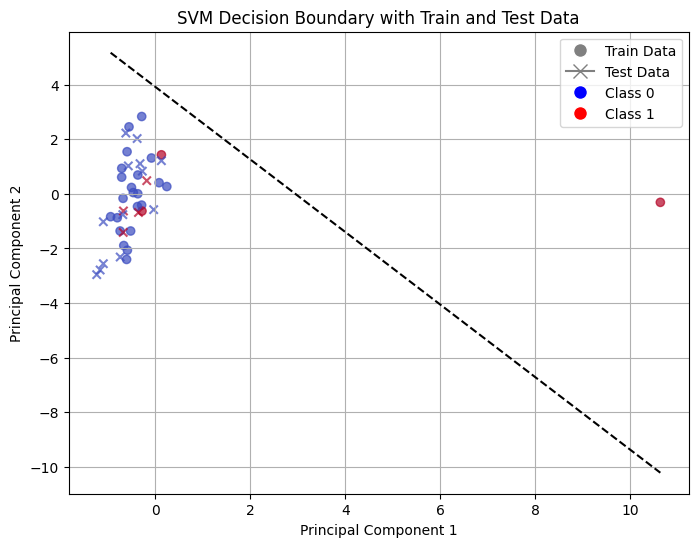

In [19]:
# Make predictions on the test set
if model.status == GRB.TIME_LIMIT or model.status == GRB.OPTIMAL: 
    w_values = [w[j].x for j in range(n_features)]
    b_value = b.x
    print("C1:", C1.X, "C2:", C2.X, "C3:", C3.X)
    print("M1:", M1.X, "M2:", M2.X, "M3:", M3.X)
    print("Optimal weights (w):", w_values)
    print("Optimal bias (b):", b_value)

    
    predictions = []
    for i in range(len(X_test)):
        prediction = sum(w_values[j] * X_test[i, j] for j in range(n_features)) + b_value
        threshold = -0.1
        predictions.append(1 if prediction >= threshold else 0)  # Classify as 1 or 0

    # Evaluate model performance
    #auc_score = auc(y_test, predictions)
    roc_score = roc_auc_score(y_test, predictions)
    accuracy = accuracy_score(y_test, predictions)
    #precision = precision_score(y_test, predictions, average='binary')
    #recall = recall_score(y_test, predictions, average='binary')
    
    
    # Print evaluation results

    print("Test Evaluation:")
    print(f"ROC Score: {roc_score:.4f}")
    print(classification_report(y_test,predictions))
    print(f"Accuracy: {accuracy:.4f}")
    #print(f"Precision: {precision:.4f}")
    #print(f"Recall: {recall:.4f}")
    
    
    #train_predictions = [1 if sum(w_values[j] * X_train[i, j] for j in range(n_features)) + b_value >= threshold else 0 for i in range(len(X_train))]
    #train_accuracy = sum(y_train[i] == train_predictions[i] for i in range(len(y_train))) / len(y_train)
    
    #print("Training Accuracy:", train_accuracy)


    
    


    # Step 1: Apply PCA to reduce to 2D
    pca = PCA(n_components=2)  # 2D for visualization
    
    X_train_reduced = pca.fit_transform(X_train)
    X_test_reduced = pca.transform(X_test)  # Apply the same PCA transformation to test data

    # Step 2: Assuming you have the weights and bias from the trained model
    
    # Here, we simulate the decision boundary for illustration
    weights_reduced = pca.transform([w_values])[0]
    # Decision boundary (hyperplane) equation in reduced space
    x1_values = np.linspace(X_train_reduced[:, 0].min(), X_train_reduced[:, 0].max(), 100)
    x2_values = -( weights_reduced[0] * x1_values + b_value) /  weights_reduced[1]  # SVM equation for decision boundary

    # Step 3: Plot
    plt.figure(figsize=(8, 6))

    # Plot training data
    train_scatter = plt.scatter(X_train_reduced[:, 0], X_train_reduced[:, 1], c=y_train, cmap='coolwarm', alpha=0.7, label='Train Data')

    # Plot test data
    test_scatter = plt.scatter(X_test_reduced[:, 0], X_test_reduced[:, 1], c=y_test, cmap='coolwarm', alpha=0.7, marker='x', label='Test Data')


    
    
    
    
    
    
    # Plot the decision boundary
    plt.plot(x1_values, x2_values, color='black', linestyle='--', label='Decision Boundary')

    # Add labels and legend
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.title('SVM Decision Boundary with Train and Test Data')
    train_patch = Line2D([0], [0], marker='o', color='w', markerfacecolor='gray', markersize=10, label='Train Data')
    test_patch = Line2D([0], [0], marker='x', color='gray', markersize=10, label='Test Data')
    class_0_patch = Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=10, label='Class 0')
    class_1_patch = Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=10, label='Class 1')
    # Add legend manually
    plt.legend(handles=[train_patch, test_patch, class_0_patch, class_1_patch], loc='best')
    plt.grid(True)
    plt.show()

In [ ]:
'''Optimize a model with 129764 rows, 92765 columns and 225429 nonzeros
Model fingerprint: 0xbe61d61c
Model has 132 quadratic objective terms
Model has 2112 quadratic constraints
Variable types: 92672 continuous, 93 integer (93 binary)
Coefficient statistics:
  Matrix range     [1e-02, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  QLMatrix range   [1e-04, 1e+00]
  Objective range  [5e-01, 5e-01]
  QObjective range [2e+00, 2e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [9e-07, 4e+01]
  QRHS range       [2e-04, 6e+00]
Presolve removed 126858 rows and 91075 columns
Presolve time: 0.01s
Presolved: 3435 rows, 2088 columns, 10433 nonzeros
Presolved model has 220 SOS constraint(s)
Presolved model has 44 bilinear constraint(s)
Warning: Model contains variables with very large bounds participating
...
Optimal solution found (tolerance 5.00e-02)
Warning: max constraint violation (6.2011e-06) exceeds tolerance
Best objective 7.641369980989e+00, best bound 7.259474403623e+00, gap 4.9977%
Optimal solution found.
Output is truncated. View as a  for rbf kerne;'''

C1: 0.010000000000000009 C2: 0.009999999999999995 C3: 0.1
M1: 15.156424658396947 M2: 18.0 M3: 34.38065824272997
Optimal weights (w): [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.09373936581977915, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Optimal bias (b): 0.9896289366493389
Test Evaluation:
ROC Score: 0.5000
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        13
           1       0.24      1.00      0.38         4

    accuracy                           0.24        17
   macro avg       0.12      0.50      0.19        17
weighted avg       0.06      0.24      0.09        17

Accuracy: 0.2353


/Users/mengyanzhu/Documents/GitHub/msf-capstone-crm/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/mengyanzhu/Documents/GitHub/msf-capstone-crm/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/mengyanzhu/Documents/GitHub/msf-capstone-crm/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to cont

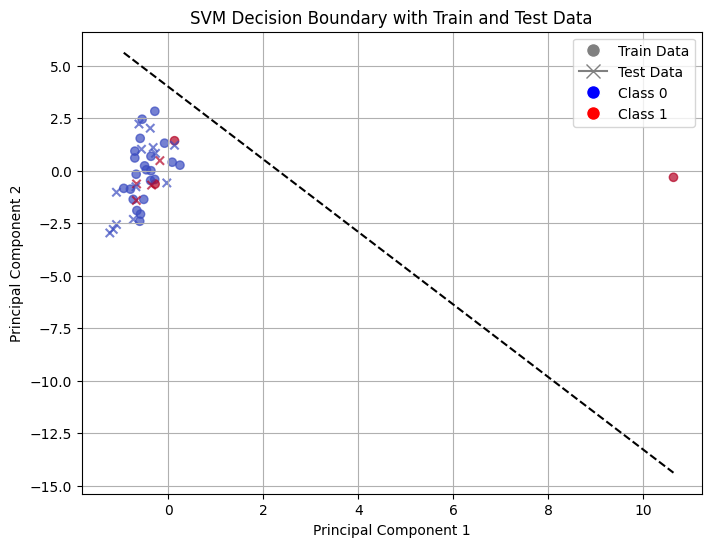

In [55]:
# Make predictions on the test set
if model.status == GRB.TIME_LIMIT or model.status == GRB.OPTIMAL: 
    w_values = [w[j].x for j in range(n_features)]
    b_value = b.x
    print("C1:", C1.X, "C2:", C2.X, "C3:", C3.X)
    print("M1:", M1.X, "M2:", M2.X, "M3:", M3.X)
    print("Optimal weights (w):", w_values)
    print("Optimal bias (b):", b_value)

    
    predictions = []
    for i in range(len(X_test)):
        prediction = sum(w_values[j] * X_test[i, j] for j in range(n_features)) + b_value
        threshold = -0.1
        predictions.append(1 if prediction >= threshold else 0)  # Classify as 1 or 0

    # Evaluate model performance
    #auc_score = auc(y_test, predictions)
    roc_score = roc_auc_score(y_test, predictions)
    accuracy = accuracy_score(y_test, predictions)
    #precision = precision_score(y_test, predictions, average='binary')
    #recall = recall_score(y_test, predictions, average='binary')
    
    
    # Print evaluation results

    print("Test Evaluation:")
    print(f"ROC Score: {roc_score:.4f}")
    print(classification_report(y_test,predictions))
    print(f"Accuracy: {accuracy:.4f}")
    #print(f"Precision: {precision:.4f}")
    #print(f"Recall: {recall:.4f}")
    
    
    #train_predictions = [1 if sum(w_values[j] * X_train[i, j] for j in range(n_features)) + b_value >= threshold else 0 for i in range(len(X_train))]
    #train_accuracy = sum(y_train[i] == train_predictions[i] for i in range(len(y_train))) / len(y_train)
    
    #print("Training Accuracy:", train_accuracy)


    
    


    # Step 1: Apply PCA to reduce to 2D
    pca = PCA(n_components=2)  # 2D for visualization
    
    X_train_reduced = pca.fit_transform(X_train)
    X_test_reduced = pca.transform(X_test)  # Apply the same PCA transformation to test data

    # Step 2: Assuming you have the weights and bias from the trained model
    
    # Here, we simulate the decision boundary for illustration
    weights_reduced = pca.transform([w_values])[0]
    # Decision boundary (hyperplane) equation in reduced space
    x1_values = np.linspace(X_train_reduced[:, 0].min(), X_train_reduced[:, 0].max(), 100)
    x2_values = -( weights_reduced[0] * x1_values + b_value) /  weights_reduced[1]  # SVM equation for decision boundary

    # Step 3: Plot
    plt.figure(figsize=(8, 6))

    # Plot training data
    train_scatter = plt.scatter(X_train_reduced[:, 0], X_train_reduced[:, 1], c=y_train, cmap='coolwarm', alpha=0.7, label='Train Data')

    # Plot test data
    test_scatter = plt.scatter(X_test_reduced[:, 0], X_test_reduced[:, 1], c=y_test, cmap='coolwarm', alpha=0.7, marker='x', label='Test Data')


    
    
    
    
    
    
    # Plot the decision boundary
    plt.plot(x1_values, x2_values, color='black', linestyle='--', label='Decision Boundary')

    # Add labels and legend
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.title('SVM Decision Boundary with Train and Test Data')
    train_patch = Line2D([0], [0], marker='o', color='w', markerfacecolor='gray', markersize=10, label='Train Data')
    test_patch = Line2D([0], [0], marker='x', color='gray', markersize=10, label='Test Data')
    class_0_patch = Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=10, label='Class 0')
    class_1_patch = Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=10, label='Class 1')
    # Add legend manually
    plt.legend(handles=[train_patch, test_patch, class_0_patch, class_1_patch], loc='best')
    plt.grid(True)
    plt.show()